In [1]:
import os
os.chdir('..')

In [2]:
from msml.ml.train_models_gp3 import get_batches_infos, get_path, get_data_all, keep_some_concs
from argparse import Namespace
import numpy as np
import random
import copy
random.seed(42)
# torch.manual_seed(42)
np.random.seed(42)



/home/simonp/anaconda3/envs/bernn_env3/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/simonp/anaconda3/envs/bernn_env3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/simonp/anaconda3/envs/bernn_env3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is 

In [3]:
batch_dates, batches_to_keep = get_batches_infos()

args = Namespace(
    log_path="./notebooks/logs/",
    log_plots=1,
    device="cpu",
    groupkfold=1,
    threshold=0.0,
    mz=2,
    rt=10,
    mzp=2,
    rtp=10,
    spd=200,
    ms_level=2,
    combat=0,
    shift=0,
    features_selection='none',
    train_on='all',
    exp_name='test',
    model_name='xgboost',
    low_ram=0,
    csv_file='inputs_none.csv',
    n_features=-1,
    fp=32,
    log='inloop',
    max_bin=256,
    sparse_matrix=0,
    remove_zeros=0,
    log1p=0,
    remove_bad_samples=1,
    min_mz=0,
    max_mz=10000,
    min_mz_parent=359,
    max_mz_parent=872,
    min_rt=0,
    max_rt=320,
    features_file='features.csv',  # Only if you use feature selection
    pool=0,
    binary=0,
    concs='na,h',
    n_repeats=5,
    ovr=0,
    test=0,
    log_shap=1,
    prune_threshold=0,
    dloss='DANN',
    warmup_after_warmup=1,
    train_after_warmup=1,
    patient_bact='',
)
print(args)  # Example usageconcs = args.concs.split(',')


Namespace(log_path='./notebooks/logs/', log_plots=1, device='cpu', groupkfold=1, threshold=0.0, mz=2, rt=10, mzp=2, rtp=10, spd=200, ms_level=2, combat=0, shift=0, features_selection='none', train_on='all', exp_name='test', model_name='xgboost', low_ram=0, csv_file='inputs_none.csv', n_features=-1, fp=32, log='inloop', max_bin=256, sparse_matrix=0, remove_zeros=0, log1p=0, remove_bad_samples=1, min_mz=0, max_mz=10000, min_mz_parent=359, max_mz_parent=872, min_rt=0, max_rt=320, features_file='features.csv', pool=0, binary=0, concs='na,h', n_repeats=5, ovr=0, test=0, log_shap=1, prune_threshold=0, dloss='DANN', warmup_after_warmup=1, train_after_warmup=1, patient_bact='')


In [4]:
batch_dates, batches_to_keep = get_batches_infos()
cropings = "mz0-10000rt0-320"
exp = f'all_{"-".join(batch_dates)}_gkf{args.groupkfold}_{cropings}_5splits'  
path, results_path = get_path(args, exp)
all_data, uniques = get_data_all(path, args)


FileNotFoundError: [Errno 2] No such file or directory: 'resources/bacteries_2024/matrices/mz2/rt10/mzp2/rtp10/thr0.0/200spd/ms2/combat0/shift0/none/loginloop/none/all_BPatients-cultures_pures-B15-B14-B13-B12-B11-B10-B9-B8-B7-B6-B5-B4-B3-B2-B1_gkf1_mz0-10000rt0-320_5splits/inputs_none.csv'

In [ ]:
def keep_some_concs(data, concs):
    mask2 = [True if x in concs else False for x in data['concs']['all']]
    data['inputs']['all'] = data['inputs']['all'].iloc[mask2]
    data['labels']['all'] = data['labels']['all'][mask2]
    data['batches']['all'] = data['batches']['all'][mask2]
    data['batches_labels']['all'] = data['batches_labels']['all'][mask2]
    data['names']['all'] = data['names']['all'][mask2]
    # data['orders']['all'] = data['orders']['all'][mask2]
    data['cats']['all'] = data['cats']['all'][mask2]
    data['urines']['all'] = data['urines']['all'][mask2]
    data['manips']['all'] = data['manips']['all'][mask2]
    data['concs']['all'] = data['concs']['all'][mask2]

    # TODO Assert that no concentration is left that should not
    try:
        assert len(np.unique(data['concs']['all'])) == len(concs)
    except Exception as e:
        print("Problem at assert len(np.unique(data['concs']['all'])) == len(concs)", e)
        raise ValueError(f'Problem with concentrations: Should have: {concs} but got {np.unique(data["concs"]["all"])}')

    return data



In [ ]:
data = copy.deepcopy(all_data)
concs = args.concs.split(',')
data = keep_some_concs(all_data, concs)

In [ ]:
import pandas as pd
import numpy as np

data['correct_label'] = {}

# --- Read results files (try/except for alternate path) ---
all_results = pd.read_csv(
    f'results/multi/mz{args.mz}/rt{args.rt}/ms{args.ms_level}/{args.spd}spd/thr{args.threshold}/all/BPatients-b15-b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_{args.n_features}_gkf{args.groupkfold}_ovr{args.ovr}_mz{args.min_mz}-{args.max_mz}rt{args.min_rt}-{args.max_rt}_{"_".join(concs)}/xgboost/saved_models/xgboost_test_individual_results_0.csv'
)
upos_results = pd.read_csv(
    f'results/multi/mz{args.mz}/rt{args.rt}/ms{args.ms_level}/{args.spd}spd/thr{args.threshold}/all/BPatients-b15-b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_{args.n_features}_gkf{args.groupkfold}_ovr{args.ovr}_mz{args.min_mz}-{args.max_mz}rt{args.min_rt}-{args.max_rt}_{"_".join(concs)}/xgboost/saved_models/xgboost_posurines_individual_results_0.csv'
)

# --- Align 'all' predictions ---
all_names = np.array(all_results['names'])
all_preds = np.array(all_results['preds'])
names_all = np.array(data['names']['all'])

# For each name in data['names']['all'], find its index in all_results['names']
all_indices = np.array([np.where(all_names == name)[0][0] for name in names_all])
data['preds'] = {}
data['preds']['all'] = all_preds[all_indices]

# --- Align 'urinespositives' predictions ---
upos_names = np.array(upos_results['names'])
upos_preds = np.array(upos_results['preds'])
names_urinespositives = np.array(data['names']['urinespositives'])

# Boolean mask: True if name is in upos_names
in_upos = np.isin(names_urinespositives, upos_names)

# Indices in upos_names for those present
upos_indices = np.full(names_urinespositives.shape, -1)
upos_indices[in_upos] = [np.where(upos_names == name)[0][0] for name in names_urinespositives[in_upos]]

# Indices in all_names for those not present in upos_names
all_indices_upos = np.full(names_urinespositives.shape, -1)

# Check which names are actually in all_names
names_not_in_upos = names_urinespositives[~in_upos]
valid_all_indices = []
valid_names = []

for name in names_not_in_upos:
    matches = np.where(all_names == name)[0]
    if len(matches) > 0:
        valid_all_indices.append(matches[0])
        valid_names.append(name)
    else:
        print(f"Warning: Name '{name}' not found in all_results")

# Only assign indices for names that were actually found
if len(valid_all_indices) > 0:
    valid_mask = np.isin(names_urinespositives, valid_names)
    all_indices_upos[valid_mask] = valid_all_indices

# Build the predictions array in the correct order
preds_urinespositives = np.empty(names_urinespositives.shape, dtype=all_preds.dtype)
preds_urinespositives[in_upos] = upos_preds[upos_indices[in_upos]]

# Only assign predictions for names that were found in all_results
valid_all_mask = all_indices_upos != -1
preds_urinespositives[valid_all_mask] = all_preds[all_indices_upos[valid_all_mask]]

# For names not found in either, you might want to handle them (e.g., set to NaN or raise an error)
missing_mask = ~(in_upos | valid_all_mask)
if np.any(missing_mask):
    missing_names = names_urinespositives[missing_mask]
    print(f"Warning: The following names were not found in either results file: {missing_names}")
    # You can choose to set these to NaN, raise an error, or handle them as you prefer
    preds_urinespositives[missing_mask] = np.nan  # or raise an error

data['preds']['urinespositives'] = preds_urinespositives

# --- Build upos_tests dict ---
data['upos_tests'] = {}

# For urinespositives: upos_test if in upos_results, else upos_train
upos_tests_urinespositives = np.where(
    in_upos,
    'upos_test',
    'upos_train'
)

# For all: 'upos_test'/'upos_train' if in urinespositives, else 'inoc'
upos_tests_all = np.full(names_all.shape, 'inoc', dtype=object)
urinespositives_mask = np.isin(names_all, names_urinespositives)
upos_tests_all[urinespositives_mask] = upos_tests_urinespositives[
    [np.where(names_urinespositives == name)[0][0] for name in names_all[urinespositives_mask]]
]

data['upos_tests']['all'] = upos_tests_all
data['upos_tests']['urinespositives'] = upos_tests_urinespositives

# Optionally, check the result
print(pd.Series(data['upos_tests']['all']).value_counts())
print(pd.Series(data['upos_tests']['urinespositives']).value_counts())

inoc    1858
dtype: int64
upos_train    75
upos_test     48
dtype: int64


In [ ]:
assert len(data['preds']['urinespositives']) == len(data['names']['urinespositives']), \
    "Length mismatch in urinespositives predictions!"
assert set(data['names']['urinespositives']) <= set(np.concatenate([upos_names, all_names])), \
    "Some urinespositives names are missing in both results files!"

In [ ]:
# Ensure names are numpy arrays for fast searching
# all_names = np.array(all_results['names'])
# all_preds = np.array(all_results['preds'])
# upos_names = np.array(upos_results['names'])
# upos_preds = np.array(upos_results['preds'])
# 
# urinespositives_names = np.array(data['names']['urinespositives'])
# 
# preds_urinespositives = []
# for name in urinespositives_names:
#     if name in upos_names:
#         idx = np.where(upos_names == name)[0][0]
#         preds_urinespositives.append(upos_preds[idx])
#     elif name in all_names:
#         idx = np.where(all_names == name)[0][0]
#         preds_urinespositives.append(all_preds[idx])
#     else:
#         preds_urinespositives.append(None)  # or np.nan, or raise an error
# 
# data['preds']['urinespositives'] = np.array(preds_urinespositives)
# data['preds']['urinespositives']

In [ ]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from umap import UMAP
from msml.ml.utils import scale_data

# Ellipse function
def get_confidence_ellipse(x, y, n_std=1.5, num_points=100):
    if len(x) < 2:
        return None, None
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    t = np.linspace(0, 2*np.pi, num_points)
    ellipse = np.array([width/2 * np.cos(t), height/2 * np.sin(t)])
    R = np.array([[np.cos(np.radians(theta)), -np.sin(np.radians(theta))],
                  [np.sin(np.radians(theta)),  np.cos(np.radians(theta))]])
    ellipse_rot = R @ ellipse
    return ellipse_rot[0], ellipse_rot[1]

def log_ord_interactive(data, uniques):
    scaler_selector = widgets.Dropdown(options=['raw', 'zscore', 'minmax2', 'standard', 'minmax', 'robust'], value='raw', description='Scaler:')
    blancs_checkbox = widgets.Checkbox(value=False, description='Blancs only')
    embedding_selector = widgets.Dropdown(options=['PCA', 'UMAP', 'LDA'], value='PCA', description='Embedding:')

    # Primary (color)
    label_type_selector = widgets.Dropdown(options=list(uniques.keys()), value='labels', description='Category:')
    label_selector = widgets.SelectMultiple(description='Highlight (color):', rows=10)

    # Secondary (opacity)
    highlight_type_selector = widgets.Dropdown(options=list(uniques.keys()), value='manips', description='Opacity by 1:')
    highlight_selector = widgets.SelectMultiple(description='Highlight (opacity 1):', rows=10)

    # Tertiary (third opacity layer)
    third_type_selector = widgets.Dropdown(options=list(uniques.keys()), value='batches', description='Opacity by 2:')
    third_selector = widgets.SelectMultiple(description='Highlight (opacity 2):', rows=10)

    fig = go.FigureWidget(layout=dict(width=900, height=900, xaxis_title='Dim 1', yaxis_title='Dim 2'))

    cmap = plt.get_cmap('tab20')
    color_maps = {
        cat: {val: f'rgb({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)})'
              for val, c in zip(list(vals), cmap(np.linspace(0, 1, len(vals))))}
        for cat, vals in uniques.items()
    }

    current_data = {}
    embedding_cache = {}

    def prepare_data():
        d = copy.deepcopy(data)
        if scaler_selector.value != 'raw':
            d, _ = scale_data(scaler_selector.value, d)
        if blancs_checkbox.value:
            for group in ['all', 'urinespositives']:
                idx = np.where(d['labels'][group] == 'blanc')[0]
                for k in ['labels','batches','batches_labels','manips','urines','concs','cats','names','preds', 'upos_tests', 'correct']:
                    d[k][group] = d[k][group][idx]
                d['inputs'][group] = d['inputs'][group].iloc[idx]
        d2 = copy.deepcopy(d)
        d2['inputs']['all'] = pd.concat([d['inputs']['all'], d['inputs']['urinespositives']])
        for k in ['labels','batches','batches_labels','manips','urines','concs','cats','names','preds', 'upos_tests', 'correct']:
            d2[k]['all'] = np.concatenate([d[k]['all'], d[k]['urinespositives']])
        # d2['urinespositives_test'] = {'all': np.concatenate([['train']*len(d['labels']['all']), ['test']*len(d['labels']['urinespositives'])])}
        d2['urinespositives'] = {}
        d2['urinespositives']['all'] = ['upos' if 'urinespositives' in urines else 'inoc' for urines in d2['names']['all']]
        d2['urinespositives']['urinespositives'] = ['upos' if 'urinespositives' in urines else 'inoc' for urines in d2['names']['urinespositives']]
        return d2

    def compute_embedding(name):
        X = current_data['inputs']['all']
        if name == 'PCA':
            return PCA(n_components=2).fit_transform(X)
        if name == 'UMAP':
            # X_pca = PCA(n_components=min(50, X.shape[1])).fit_transform(X)
            return UMAP(n_components=2).fit_transform(X)
        if name == 'LDA':
            variable = label_type_selector.value
            try:
                return LDA(n_components=2).fit(X, current_data[variable]['all']).transform(X)
            except:
                pass
        return None

    def full_recompute(*_):
        d = prepare_data()
        current_data.clear()
        current_data.update(d)
        embedding_cache.clear()

        cat_main = label_type_selector.value
        cat_highlight = highlight_type_selector.value
        cat_third = third_type_selector.value

        valid_labels = np.unique(d[cat_main]['all'])
        valid_highlights = np.unique(d[cat_highlight]['all'])
        valid_third = np.unique(d[cat_third]['all'])

        label_selector.options = valid_labels
        label_selector.value = tuple(valid_labels)
        highlight_selector.options = valid_highlights
        highlight_selector.value = tuple(valid_highlights)
        third_selector.options = valid_third
        third_selector.value = tuple(valid_third)

        update_plot()

    def update_plot(*_):
        emb_name = embedding_selector.value
        if emb_name not in embedding_cache:
            result = compute_embedding(emb_name)
            if result is not None:
                embedding_cache[emb_name] = result
            else:
                fig.data = []
                return

        emb = embedding_cache[emb_name]
        d = current_data

        cat_main = label_type_selector.value
        cat_highlight = highlight_type_selector.value
        cat_third = third_type_selector.value

        df = pd.DataFrame(emb, columns=['Dim 1','Dim 2'])
        df['Label'] = d[cat_main]['all']
        df['Highlight'] = d[cat_highlight]['all']
        df['Third'] = d[cat_third]['all']

        fig.data = []

        for lbl in label_selector.options:
            pts = df[df['Label'] == lbl]

            pts_sel = pts[
                (pts['Label'].isin(label_selector.value)) &
                (pts['Highlight'].isin(highlight_selector.value)) &
                (pts['Third'].isin(third_selector.value))
            ]
            pts_not_sel = pts.drop(pts_sel.index)

            if not pts_not_sel.empty:
                fig.add_trace(go.Scatter(
                    x=pts_not_sel['Dim 1'], y=pts_not_sel['Dim 2'], mode='markers',
                    marker=dict(size=10, opacity=0.1, color=color_maps[cat_main][lbl]),
                    showlegend=False
                ))

            if not pts_sel.empty:
                fig.add_trace(go.Scatter(
                    x=pts_sel['Dim 1'], y=pts_sel['Dim 2'], mode='markers',
                    name=str(lbl),
                    marker=dict(size=10, opacity=1.0, color=color_maps[cat_main][lbl], line=dict(width=1, color='black'))
                ))

                if len(pts_sel) >= 2:
                    ell_x, ell_y = get_confidence_ellipse(pts_sel['Dim 1'], pts_sel['Dim 2'])
                    if ell_x is not None:
                        fig.add_trace(go.Scatter(
                            x=pts_sel['Dim 1'].mean() + ell_x,
                            y=pts_sel['Dim 2'].mean() + ell_y,
                            mode='lines',
                            line=dict(color=color_maps[cat_main][lbl], width=2),
                            showlegend=False
                        ))

        fig.update_layout(title=f"{emb_name}: {cat_main} color + 3 filters (AND logic)")

    # Observers
    scaler_selector.observe(full_recompute, names='value')
    blancs_checkbox.observe(full_recompute, names='value')
    embedding_selector.observe(update_plot, names='value')
    label_selector.observe(update_plot, names='value')
    highlight_selector.observe(update_plot, names='value')
    third_selector.observe(update_plot, names='value')

    def on_category_change(change):
        cat = change['new']
        valid_labels = np.unique(current_data[cat]['all'])
        label_selector.options = valid_labels
        label_selector.value = tuple(valid_labels)
        update_plot()

    def on_highlight_category_change(change):
        cat = change['new']
        valid_highlights = np.unique(current_data[cat]['all'])
        highlight_selector.options = valid_highlights
        highlight_selector.value = tuple(valid_highlights)
        update_plot()

    def on_third_category_change(change):
        cat = change['new']
        valid_third = np.unique(current_data[cat]['all'])
        third_selector.options = valid_third
        third_selector.value = tuple(valid_third)
        update_plot()

    label_type_selector.observe(on_category_change, names='value')
    highlight_type_selector.observe(on_highlight_category_change, names='value')
    third_type_selector.observe(on_third_category_change, names='value')

    display(widgets.HBox([
        widgets.VBox([
            scaler_selector, blancs_checkbox,
            embedding_selector,
            label_type_selector, label_selector,
            highlight_type_selector, highlight_selector,
            third_type_selector, third_selector
        ]),
        fig
    ]))

    full_recompute()


In [ ]:
%matplotlib inline
# from msml.ml.loggings import log_ord
import pandas as pd
import os


data = {
    'inputs': {
        'all': data['inputs']['all'],
        'urinespositives': data['inputs']['urinespositives'],
    },
    'preds': {
        'all': data['preds']['all'],
        'urinespositives': data['preds']['urinespositives'],
    },
    'labels': {
        'all': data['labels']['all'],
        'urinespositives': data['labels']['urinespositives'],
    },
    'batches': {
        'all': data['batches']['all'],
        'urinespositives': data['batches']['urinespositives'],
    },
    'batches_labels': {
        'all': data['batches_labels']['all'],
        'urinespositives': data['batches_labels']['urinespositives'],
    },
    'manips': {
        'all': data['manips']['all'],
        'urinespositives': data['manips']['urinespositives'],
    },
    'urines': {
        'all': data['urines']['all'],
        'urinespositives': data['urines']['urinespositives'],
    },
    'concs': {
        'all': data['concs']['all'],
        'urinespositives': data['concs']['urinespositives'],
    },
    'cats': {
        'all': data['cats']['all'],
        'urinespositives': data['cats']['urinespositives'],
    },
    'names': {
        'all': data['names']['all'],
        'urinespositives': data['names']['urinespositives'],
    },
    'upos_tests': {
        'all': data['upos_tests']['all'],
        'urinespositives': data['upos_tests']['urinespositives'],
    },
}
# Create new dict to store correctness
data['correct'] = {
    'all': data['preds']['all'] == data['labels']['all'],
    'urinespositives': data['preds']['urinespositives'] == data['labels']['urinespositives'],
}
uniques = {
    'labels': np.unique(np.concatenate((data['labels']['all'], data['labels']['urinespositives']))),
    'preds': np.unique(np.concatenate((data['preds']['all'], data['preds']['urinespositives']))),
    'batches': np.unique(np.concatenate((data['batches']['all'], data['batches']['urinespositives']))),
    'batches_labels': np.unique(np.concatenate((data['batches_labels']['all'], data['batches_labels']['urinespositives']))),
    'manips': np.unique(np.concatenate((data['manips']['all'], data['manips']['urinespositives']))),
    'urines': np.unique(np.concatenate((data['urines']['all'], data['urines']['urinespositives']))),
    'concs': np.unique(np.concatenate((data['concs']['all'], data['concs']['urinespositives']))),
    'urinespositives': np.array(['upos', 'inoc']),
    'correct': np.array([True, False]),
    'upos_tests': np.array(['inoc', 'upos_train', 'upos_test'])
}

output_path = "./ords"
os.makedirs(output_path, exist_ok=True)
step_name = "inputs"



# Raw

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(data['labels']['urinespositives'], data['preds']['urinespositives'])

0.3932947801008569

In [ ]:
# Note: The LDA is of the category first chosen. Afterwards LDA wont recompute unless rerun the cell
log_ord_interactive(data, uniques)

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score
import pandas as pd
# Categories to compare
categories = ['labels', 'batches', 'manips', 'urines']

# Prepare a DataFrame to store AMI values
ami_matrix = pd.DataFrame(index=categories, columns=categories, dtype=float)

# Compute AMI for each pair
for cat1 in categories:
    for cat2 in categories:
        if cat1 == cat2:
            ami_matrix.loc[cat1, cat2] = 1.0  # AMI with itself is 1
        else:
            ami_matrix.loc[cat1, cat2] = adjusted_mutual_info_score(
                data[cat1]['all'], data[cat2]['all']
            )

# Display the table
ami_matrix.style.background_gradient(cmap='viridis')

,labels,batches,manips,urines
labels,1.000000,0.317179,0.834834,-0.056388
batches,0.317179,1.000000,0.416323,-0.000105
manips,0.834834,0.416323,1.000000,-0.088396
urines,-0.056388,-0.000105,-0.088396,1.000000


In [ ]:
from sklearn.metrics import adjusted_mutual_info_score
import pandas as pd
import numpy as np

# Filter data for blancs only
blanc_mask = data['labels']['all'] == 'blanc'

# Create blancs-only data
blancs_data = {}
for category in ['labels', 'batches', 'manips', 'urines']:
    blancs_data[category] = data[category]['all'][blanc_mask]

print(f"Number of blanc samples: {np.sum(blanc_mask)}")
print(f"Unique values in each category for blancs:")
for category in ['labels', 'batches', 'manips', 'urines']:
    unique_vals = np.unique(blancs_data[category])
    print(f"  {category}: {len(unique_vals)} unique values - {unique_vals}")

# Categories to compare
categories = ['labels', 'batches', 'manips', 'urines']

# Prepare a DataFrame to store AMI values for blancs
ami_matrix_blancs = pd.DataFrame(index=categories, columns=categories, dtype=float)

# Compute AMI for each pair (blancs only)
for cat1 in categories:
    for cat2 in categories:
        if cat1 == cat2:
            ami_matrix_blancs.loc[cat1, cat2] = 1.0  # AMI with itself is 1
        else:
            # Only compute AMI if both categories have more than one unique value
            if len(np.unique(blancs_data[cat1])) > 1 and len(np.unique(blancs_data[cat2])) > 1:
                ami_matrix_blancs.loc[cat1, cat2] = adjusted_mutual_info_score(
                    blancs_data[cat1], blancs_data[cat2]
                )
            else:
                ami_matrix_blancs.loc[cat1, cat2] = 0.0  # No mutual information if one category has only one value

print("\nAMI Matrix for Blancs Only:")
print(ami_matrix_blancs)

# Display the table with styling
ami_matrix_blancs.style.background_gradient(cmap='viridis')

Number of blanc samples: 345
Unique values in each category for blancs:
  labels: 1 unique values - ['blanc']
  batches: 15 unique values - [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  manips: 5 unique values - ['231116' '240202' '240307' '240417' '240604']
  urines: 97 unique values - ['u001' 'u002' 'u003' 'u004' 'u005' 'u006' 'u007' 'u008' 'u009' 'u010'
 'u011' 'u012' 'u013' 'u014' 'u016' 'u017' 'u019' 'u020' 'u021' 'u022'
 'u024' 'u027' 'u033' 'u035' 'u036' 'u037' 'u038' 'u039' 'u040' 'u041'
 'u042' 'u043' 'u044' 'u045' 'u046' 'u047' 'u048' 'u049' 'u052' 'u054'
 'u055' 'u056' 'u057' 'u058' 'u059' 'u060' 'u061' 'u062' 'u063' 'u064'
 'u065' 'u066' 'u067' 'u068' 'u069' 'u070' 'u073' 'u074' 'u077' 'u081'
 'u082' 'u084' 'u088' 'u089' 'u090' 'u092' 'u094' 'u095' 'u096' 'u097'
 'u098' 'u099' 'u103' 'u104' 'u107' 'u108' 'u109' 'u110' 'u111' 'u112'
 'u113' 'u114' 'u115' 'u116' 'u117' 'u118' 'u119' 'u120' 'u121' 'u122'
 'u123' 'u124' 'u126' 'u127' 'u128' 'u129' 'u131']

AMI Matrix for Bla

,labels,batches,manips,urines
labels,1.000000,0.000000,0.000000,0.000000
batches,0.000000,1.000000,0.697336,-0.056617
manips,0.000000,0.697336,1.000000,-0.165714
urines,0.000000,-0.056617,-0.165714,1.000000


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, matthews_corrcoef, adjusted_mutual_info_score
import numpy as np
import pandas as pd

# --- Setup Data and Splitter ---
# We use the 'all' group which contains both 'inoc' and 'urinespositives'
X = data['inputs']['all']
true_labels = data['labels']['all']
true_batches = data['batches_labels']['all'] # Using string labels for clarity

# Use a stratified split to ensure batches are represented proportionally
# We'll use a single split for this demonstration (n_splits=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, test_index = next(sss.split(X, true_batches))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_labels_train, y_labels_test = true_labels[train_index], true_labels[test_index]
y_batches_train, y_batches_test = true_batches[train_index], true_batches[test_index]

# --- Method A: Direct Batch Classification (Detecting the Effect) ---
print("--- Method A: Direct Batch Classification ---")
print("Asks: 'Is there a systematic signal in my data that corresponds to the batch?'\n")

# Train a k-NN to predict the batch directly from the data
knn_batch = KNeighborsClassifier(n_neighbors=5)
knn_batch.fit(X_train, y_batches_train)
predicted_batches = knn_batch.predict(X_test)

# Evaluate how well we can predict the batch
batch_accuracy = accuracy_score(y_batches_test, predicted_batches)
batch_mcc = matthews_corrcoef(y_batches_test, predicted_batches)

print(f"Accuracy of predicting batch from data: {batch_accuracy:.2%}")
print(f"MCC of predicting batch from data: {batch_mcc:.3f}")
print("\nInterpretation: A high accuracy/MCC (>0.5) suggests a strong batch effect is present in the data.\n")


# --- Method B: Indirect AMI Analysis (Measuring the Consequence) ---
print("--- Method B: Indirect AMI Analysis ---")
print("Asks: 'Are my model's predictions for the *biology* correlated with the batch?'\n")

# 1. Train a k-NN to predict the biological label
knn_bio = KNeighborsClassifier(n_neighbors=5)
knn_bio.fit(X_train, y_batches_train)
predicted_batches = knn_bio.predict(X_test)

# 2. Calculate AMI between the model's biological predictions and the true batches
ami_score = adjusted_mutual_info_score(predicted_batches, y_batches_test)

print(f"Adjusted Mutual Info (AMI) between biological predictions and true batches: {ami_score:.3f}")
print("\nInterpretation: A high AMI score suggests the model's predictions are strongly associated with the batch, meaning it might be 'cheating' by learning the batch artifact instead of (or in addition to) the biology.")

--- Method A: Direct Batch Classification ---
Asks: 'Is there a systematic signal in my data that corresponds to the batch?'

Accuracy of predicting batch from data: 54.30%
MCC of predicting batch from data: 0.512

Interpretation: A high accuracy/MCC (>0.5) suggests a strong batch effect is present in the data.

--- Method B: Indirect AMI Analysis ---
Asks: 'Are my model's predictions for the *biology* correlated with the batch?'

Accuracy of predicting batch from data: 54.30%
MCC of predicting batch from data: 0.512

Interpretation: A high accuracy/MCC (>0.5) suggests a strong batch effect is present in the data.

--- Method B: Indirect AMI Analysis ---
Asks: 'Are my model's predictions for the *biology* correlated with the batch?'

Adjusted Mutual Info (AMI) between biological predictions and true batches: 0.389

Interpretation: A high AMI score suggests the model's predictions are strongly associated with the batch, meaning it might be 'cheating' by learning the batch artifact inste

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, adjusted_mutual_info_score
import numpy as np
import pandas as pd

# --- Setup Data (Blancs Only, No Split) ---
# Filter for blancs only
blanc_mask = data['labels']['all'] == 'blanc'
X = data['inputs']['all'].iloc[blanc_mask]
true_labels = data['labels']['all'][blanc_mask]
true_batches = data['batches_labels']['all'][blanc_mask]
true_manips = data['manips']['all'][blanc_mask]
true_urines = data['urines']['all'][blanc_mask]

print(f"Number of blanc samples: {len(X)}")
print(f"Unique batches in blancs: {np.unique(true_batches)}")
print(f"Unique manips in blancs: {np.unique(true_manips)}")
print(f"Unique urines in blancs: {np.unique(true_urines)}")

# Define the variables to analyze
analysis_vars = {
    'labels': true_labels,
    'batches': true_batches, 
    'manips': true_manips,
    'urines': true_urines
}

print("\n" + "="*80)
print("COMPREHENSIVE BATCH EFFECT ANALYSIS FOR BLANCS")
print("="*80)

for var_name, var_data in analysis_vars.items():
    print(f"\n{'='*20} ANALYZING: {var_name.upper()} {'='*20}")
    
    # Skip if only one unique value (no variation to predict)
    unique_vals = np.unique(var_data)
    if len(unique_vals) <= 1:
        print(f"Skipping {var_name} - only {len(unique_vals)} unique value(s): {unique_vals}")
        continue
    
    print(f"Unique values in {var_name}: {len(unique_vals)} - {unique_vals}")
    
    # --- Method A: Predicting BATCHES from VARIABLE ---
    print(f"\n--- Method A: Predicting BATCHES from {var_name.upper()} ---")
    print(f"Question: 'Can we predict the batch from the {var_name} data?'")
    
    try:
        # Adjust k-neighbors based on data size and unique values
        k = min(5, len(X)//2, len(unique_vals))
        if k < 1:
            k = 1
            
        knn_var = KNeighborsClassifier(n_neighbors=k)
        knn_var.fit(X, true_batches)
        predicted_batches_from_var = knn_var.predict(X)
        
        # Evaluate how well we can predict the batch from this variable
        batch_accuracy = accuracy_score(true_batches, predicted_batches_from_var)
        
        print(f"Accuracy of predicting BATCH from {var_name} data: {batch_accuracy:.2%}")
        print(f"Interpretation: High accuracy suggests batch effect in {var_name} data")
        
    except Exception as e:
        print(f"Error in batch prediction for {var_name}: {e}")
    
    # --- Method B: Predicting the VARIABLE from batch ---
    print(f"\n--- Method B: Predicting {var_name.upper()} from BATCH ---")
    print(f"Question: 'Can we predict {var_name} from the batch information?'")
    
    try:
        knn_batch_to_var = KNeighborsClassifier(n_neighbors=k)
        knn_batch_to_var.fit(X, var_data)
        predicted_var_from_batch = knn_batch_to_var.predict(X)
        
        var_accuracy = accuracy_score(var_data, predicted_var_from_batch)
        
        print(f"Accuracy of predicting {var_name.upper()} from batch data: {var_accuracy:.2%}")
        print(f"Interpretation: High accuracy suggests {var_name} is confounded with batch")
        
    except Exception as e:
        print(f"Error in {var_name} prediction from batch: {e}")
    
    # --- Method C: AMI Analysis ---
    print(f"\n--- Method C: Mutual Information Analysis ---")
    
    try:
        # AMI between variable and batch
        ami_var_batch = adjusted_mutual_info_score(var_data, true_batches)
        print(f"AMI({var_name}, batch): {ami_var_batch:.3f}")
        
        # AMI between predicted variable and batch
        if 'predicted_var_from_batch' in locals():
            ami_pred_batch = adjusted_mutual_info_score(predicted_var_from_batch, true_batches)
            print(f"AMI(predicted_{var_name}, batch): {ami_pred_batch:.3f}")
        
        print(f"Interpretation: Higher AMI values indicate stronger association between {var_name} and batch")
        
    except Exception as e:
        print(f"Error in AMI calculation for {var_name}: {e}")
    
    # --- Summary Statistics ---
    print(f"\n--- Summary for {var_name.upper()} ---")
    print(f"Unique {var_name} values: {np.unique(var_data, return_counts=True)}")
    print(f"Unique batch values: {np.unique(true_batches, return_counts=True)}")

print(f"\n{'='*80}")
print("OVERALL INTERPRETATION:")
print("- High prediction accuracies suggest systematic relationships")
print("- High AMI scores indicate strong mutual information")
print("- For blancs, ideally we want low values (minimal batch effects)")
print("="*80)

Number of blanc samples: 345
Unique batches in blancs: ['b1' 'b10' 'b11' 'b12' 'b13' 'b14' 'b15' 'b2' 'b3' 'b4' 'b5' 'b6' 'b7'
 'b8' 'b9']

--- Method A: Direct Batch Classification (Blancs Only) ---
Asks: 'Is there a systematic signal in my blanc data that corresponds to the batch?'

Accuracy of predicting batch from blanc data: 74.49%

Interpretation: A high accuracy (>0.5) suggests a strong batch effect is present in the blanc data.

--- Method B: Indirect AMI Analysis (Blancs Only) ---
Asks: 'Are my model's predictions for the *biology* correlated with the batch in blancs?'

Accuracy of predicting batch from blanc data: 74.49%

Interpretation: A high accuracy (>0.5) suggests a strong batch effect is present in the blanc data.

--- Method B: Indirect AMI Analysis (Blancs Only) ---
Asks: 'Are my model's predictions for the *biology* correlated with the batch in blancs?'

Adjusted Mutual Info (AMI) between biological predictions and true batches: 0.620

Interpretation: A high AMI scor

In [ ]:
features = []
for label in uniques['labels']:
    try:
        df = pd.read_csv(f'results/multi/mz{args.mz}/rt{args.rt}/ms{args.ms_level}/{args.spd}spd/thr0.0/all/BPatients-b15-b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_{args.n_features}_gkf{args.groupkfold}_ovr{args.ovr}_mz{args.min_mz}-{args.max_mz}rt{args.min_rt}-{args.max_rt}_na_h/xgboost/valid_linear_shap_{label}_abs.csv')
        features.extend(df.loc[:, 'Unnamed: 0'].tolist())
    except:
        print(f'results/multi/mz{args.mz}/rt{args.rt}/ms{args.ms_level}/{args.spd}spd/thr0.0/all/BPatients-b15-b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_{args.n_features}_gkf{args.groupkfold}_ovr{args.ovr}_mz{args.min_mz}-{args.max_mz}rt{args.min_rt}-{args.max_rt}_na_h/xgboost/valid_linear_shap_{label}_abs.csv')
len(features)


results/multi/mz2/rt10/ms2/200spd/thr0.0/all/BPatients-b15-b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf1_ovr0_mz0-10000rt0-320_na_h/xgboost/test_linear_shap_aba_abs.csv
results/multi/mz2/rt10/ms2/200spd/thr0.0/all/BPatients-b15-b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf1_ovr0_mz0-10000rt0-320_na_h/xgboost/test_linear_shap_api_abs.csv
results/multi/mz2/rt10/ms2/200spd/thr0.0/all/BPatients-b15-b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf1_ovr0_mz0-10000rt0-320_na_h/xgboost/test_linear_shap_aur_abs.csv
results/multi/mz2/rt10/ms2/200spd/thr0.0/all/BPatients-b15-b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf1_ovr0_mz0-10000rt0-320_na_h/xgboost/test_linear_shap_blanc_abs.csv
results/multi/mz2/rt10/ms2/200spd/thr0.0/all/BPatients-b15-b14-b13-b12-b11-b10-b9-b8-b7-b6-b5-b4-b3-b2-b1_binary0_-1_gkf1_ovr0_mz0-10000rt0-320_na_h/xgboost/test_linear_shap_cal_abs.csv
results/multi/mz2/rt10/ms2/200spd/thr0.0/all/BPatients-b15-b14-b13-b

0

In [ ]:
features

['359.0_10_962',
 '378.0_40_736',
 '682.0_30_1464',
 '701.0_60_386',
 '701.0_80_1176',
 '758.0_180_1800',
 '777.0_30_752',
 '853.0_110_216',
 '872.0_60_248',
 '359.0_10_872',
 '359.0_10_972',
 '454.0_160_1222',
 '606.0_140_182',
 '739.0_190_1758',
 '796.0_20_1644',
 '815.0_190_410',
 '511.0_60_504',
 '701.0_230_156',
 '758.0_230_1514',
 '359.0_10_1716',
 '492.0_80_398',
 '568.0_40_744',
 '625.0_170_320',
 '815.0_30_1310',
 '834.0_240_1770',
 '359.0_30_816',
 '359.0_50_1272',
 '720.0_190_1042',
 '815.0_250_1708',
 '359.0_10_1668',
 '359.0_10_1732',
 '359.0_10_1736',
 '397.0_10_1598',
 '815.0_240_1322',
 '853.0_270_148',
 '530.0_40_1082',
 '758.0_210_1348',
 '872.0_190_1576',
 '359.0_10_1628',
 '587.0_190_1544',
 '777.0_30_1798',
 '359.0_10_770',
 '397.0_60_622',
 '701.0_150_1212',
 '796.0_240_840',
 '834.0_270_462',
 '378.0_80_1500',
 '853.0_240_1348',
 '853.0_260_608']

In [ ]:
new_data = copy.deepcopy(data)
new_data['inputs']['all'] = new_data['inputs']['all'].loc[:, features]
new_data['inputs']['urinespositives'] = new_data['inputs']['urinespositives'].loc[:, features]
new_data['inputs']['all'].shape

(1858, 49)

In [ ]:
log_ord_interactive(new_data, uniques)

# Check Performance by Batch and Manip

In [ ]:
# Calculate the performance metric (e.g., accuracy, MCC) per batch and per manip for your patient samples.

import pandas as pd
from sklearn.metrics import accuracy_score, matthews_corrcoef

# Suppose you have predictions and true labels for patients
patient_batches = data['batches_labels']['urinespositives']
patient_manips = data['manips']['urinespositives']
patient_labels = data['labels']['urinespositives']
patient_preds = data['preds']['urinespositives']

# By batch
batch_perf = {}
for batch in np.unique(patient_batches):
    mask = patient_batches == batch
    if np.sum(mask) > 1:
        acc = accuracy_score(patient_labels[mask], patient_preds[mask])
        batch_perf[batch] = acc
print("Accuracy by batch:", batch_perf)

# By manip
manip_perf = {}
for manip in np.unique(patient_manips):
    mask = patient_manips == manip
    if np.sum(mask) > 1:
        acc = accuracy_score(patient_labels[mask], patient_preds[mask])
        manip_perf[manip] = acc
print("Accuracy by manip:", manip_perf)

Accuracy by batch: {'b10': 0.5277777777777778, 'b11': 0.6875, 'bpatients': 0.02564102564102564}
Accuracy by manip: {'20250312': 0.02564102564102564, '231206': 0.5384615384615384, '231207': 0.6666666666666666, '231213': 0.7, '231214': 0.7894736842105263, '240424': 0.5277777777777778}


# 2. Visualize Performance

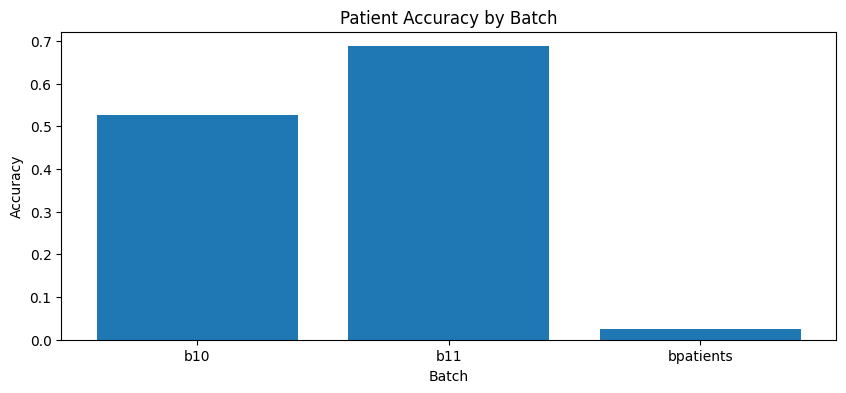

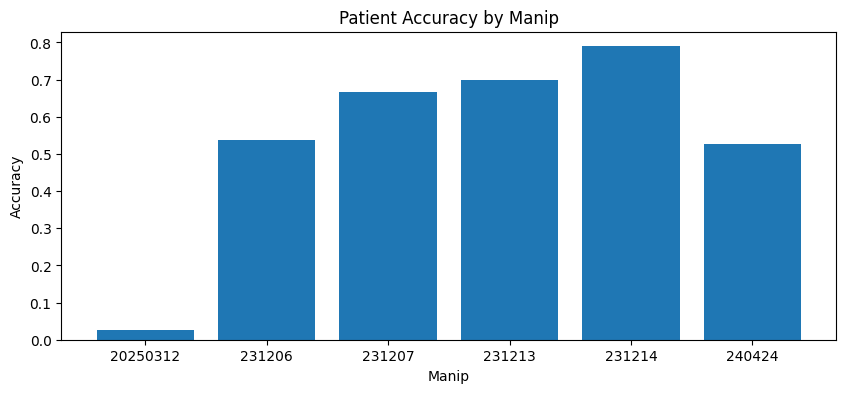

In [ ]:
import matplotlib.pyplot as plt

# Batch
plt.figure(figsize=(10,4))
plt.bar(batch_perf.keys(), batch_perf.values())
plt.title("Patient Accuracy by Batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

# Manip
plt.figure(figsize=(10,4))
plt.bar(manip_perf.keys(), manip_perf.values())
plt.title("Patient Accuracy by Manip")
plt.xlabel("Manip")
plt.ylabel("Accuracy")
plt.show()

# 3. Test for Association (AMI or Cramér’s V)

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score

# Create a misclassification vector
misclassified = patient_labels != patient_preds

# AMI between misclassification and batch
ami_batch = adjusted_mutual_info_score(misclassified, patient_batches)
ami_manip = adjusted_mutual_info_score(misclassified, patient_manips)
print(f"AMI(misclassified, batch): {ami_batch:.3f}")
print(f"AMI(misclassified, manip): {ami_manip:.3f}")

AMI(misclassified, batch): 0.219
AMI(misclassified, manip): 0.168


In [ ]:
from sklearn.metrics import adjusted_mutual_info_score
import numpy as np

# --- Misclassification vectors ---
misclassified_bpatients = data['labels']['urinespositives'] != data['preds']['urinespositives']
misclassified_test = data['labels']['all'] != data['preds']['all']

# --- Metadata vectors ---
bpatients_batches = data['batches']['urinespositives']
test_batches = data['batches']['all']
bpatients_manips = data['manips']['urinespositives']
test_manips = data['manips']['all']

# --- AMI: misclassification vs batch ---
ami_bpatients_batch = adjusted_mutual_info_score(misclassified_bpatients, bpatients_batches)
ami_test_batch = adjusted_mutual_info_score(misclassified_test, test_batches)

# --- AMI: misclassification vs manip ---
ami_bpatients_manip = adjusted_mutual_info_score(misclassified_bpatients, bpatients_manips)
ami_test_manip = adjusted_mutual_info_score(misclassified_test, test_manips)

# --- Print results ---
print("AMI(misclassified, batch):")
print(f"  BPatients: {ami_bpatients_batch:.3f}")
print(f"  Test:      {ami_test_batch:.3f}\n")

print("AMI(misclassified, manip):")
print(f"  BPatients: {ami_bpatients_manip:.3f}")
print(f"  Test:      {ami_test_manip:.3f}")

AMI(misclassified, batch):
  BPatients: 0.219
  Test:      0.002

AMI(misclassified, manip):
  BPatients: 0.168
  Test:      0.009


# 4. Check for Confounding

In [ ]:
ami_batch_manip = adjusted_mutual_info_score(patient_batches, patient_manips)
print(f"AMI(batch, manip): {ami_batch_manip:.3f}")

AMI(batch, manip): 0.804


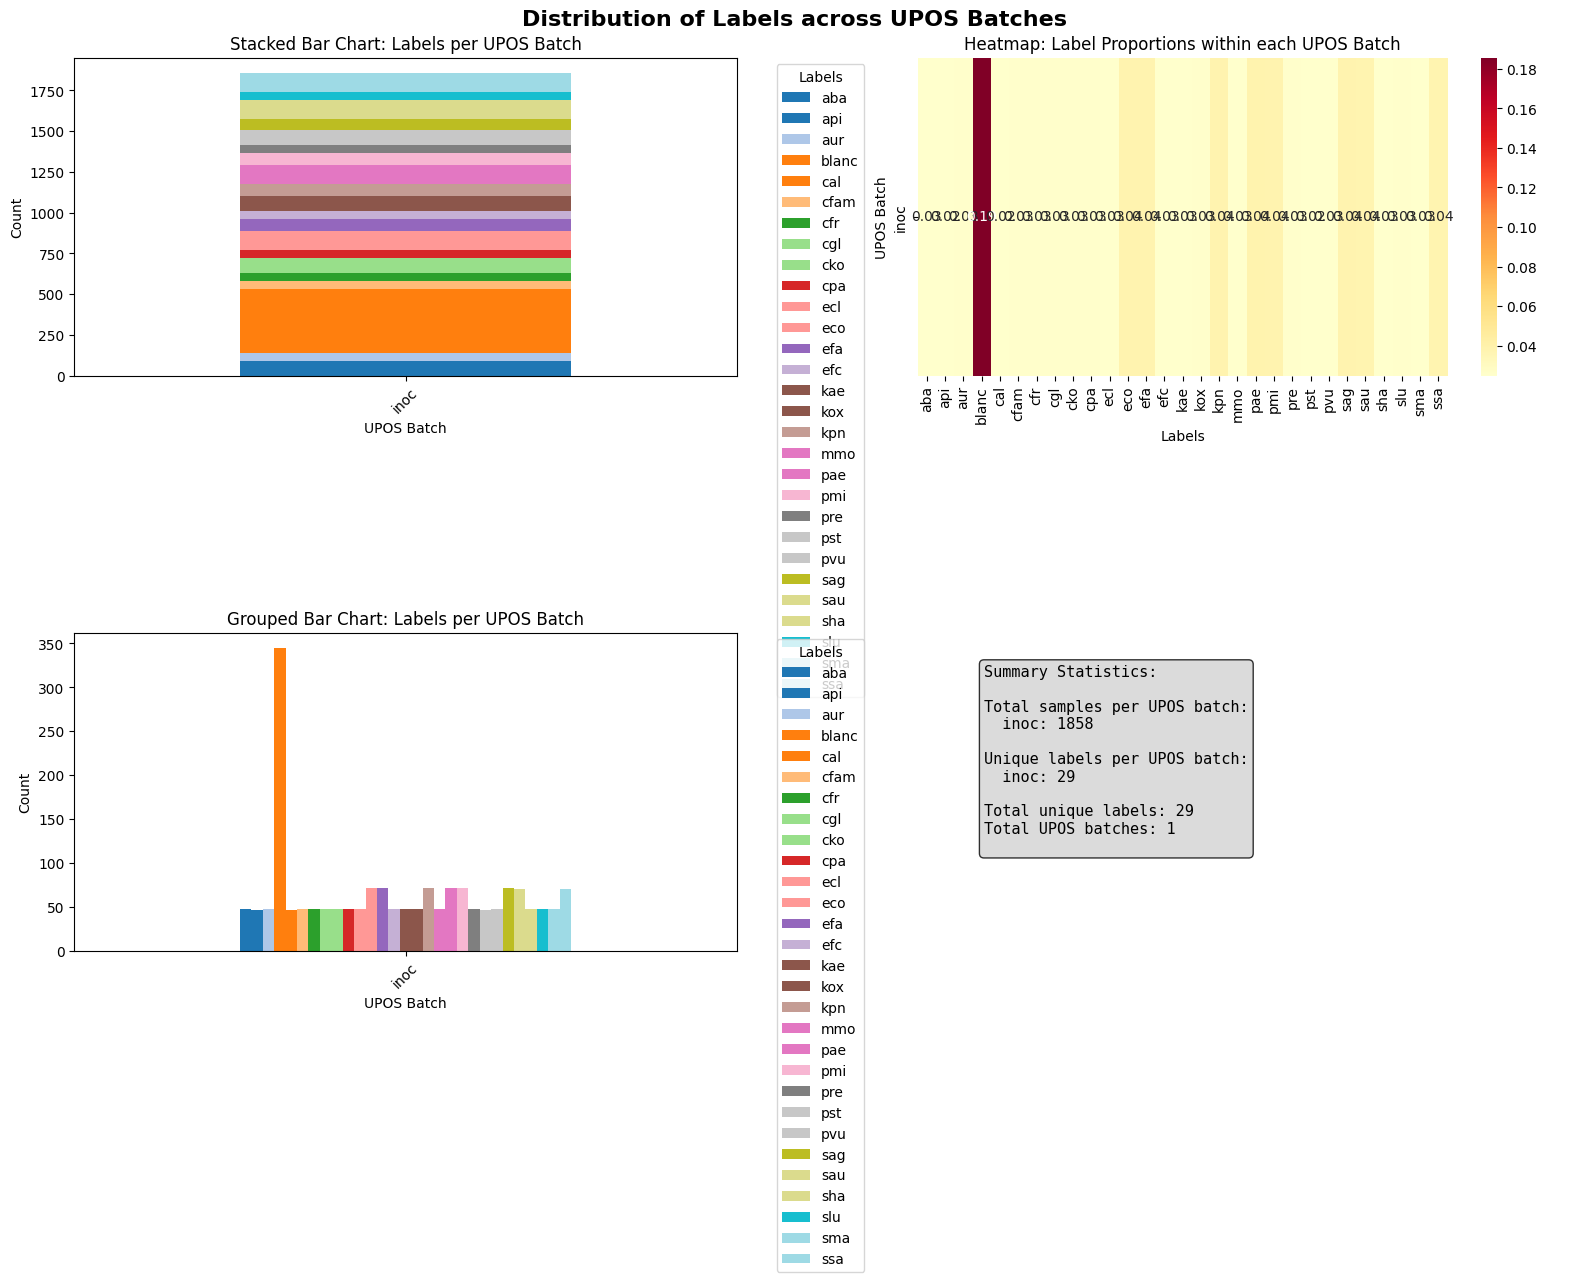

Detailed Breakdown of Labels by UPOS Batch:

INOC:
  aba: 47 samples (2.5%)
  api: 46 samples (2.5%)
  aur: 48 samples (2.6%)
  blanc: 345 samples (18.6%)
  cal: 46 samples (2.5%)
  cfam: 48 samples (2.6%)
  cfr: 48 samples (2.6%)
  cgl: 48 samples (2.6%)
  cko: 48 samples (2.6%)
  cpa: 48 samples (2.6%)
  ecl: 47 samples (2.5%)
  eco: 71 samples (3.8%)
  efa: 71 samples (3.8%)
  efc: 47 samples (2.5%)
  kae: 47 samples (2.5%)
  kox: 48 samples (2.6%)
  kpn: 71 samples (3.8%)
  mmo: 47 samples (2.5%)
  pae: 72 samples (3.9%)
  pmi: 71 samples (3.8%)
  pre: 48 samples (2.6%)
  pst: 46 samples (2.5%)
  pvu: 47 samples (2.5%)
  sag: 71 samples (3.8%)
  sau: 70 samples (3.8%)
  sha: 47 samples (2.5%)
  slu: 48 samples (2.6%)
  sma: 47 samples (2.5%)
  ssa: 70 samples (3.8%)

Crosstab Table (Counts):
label       aba  api  aur  blanc  cal  cfam  cfr  cgl  cko  cpa  ...  pmi  \
upos_batch                                                       ...        
inoc         47   46   48    345   46  

<Figure size 1200x800 with 0 Axes>

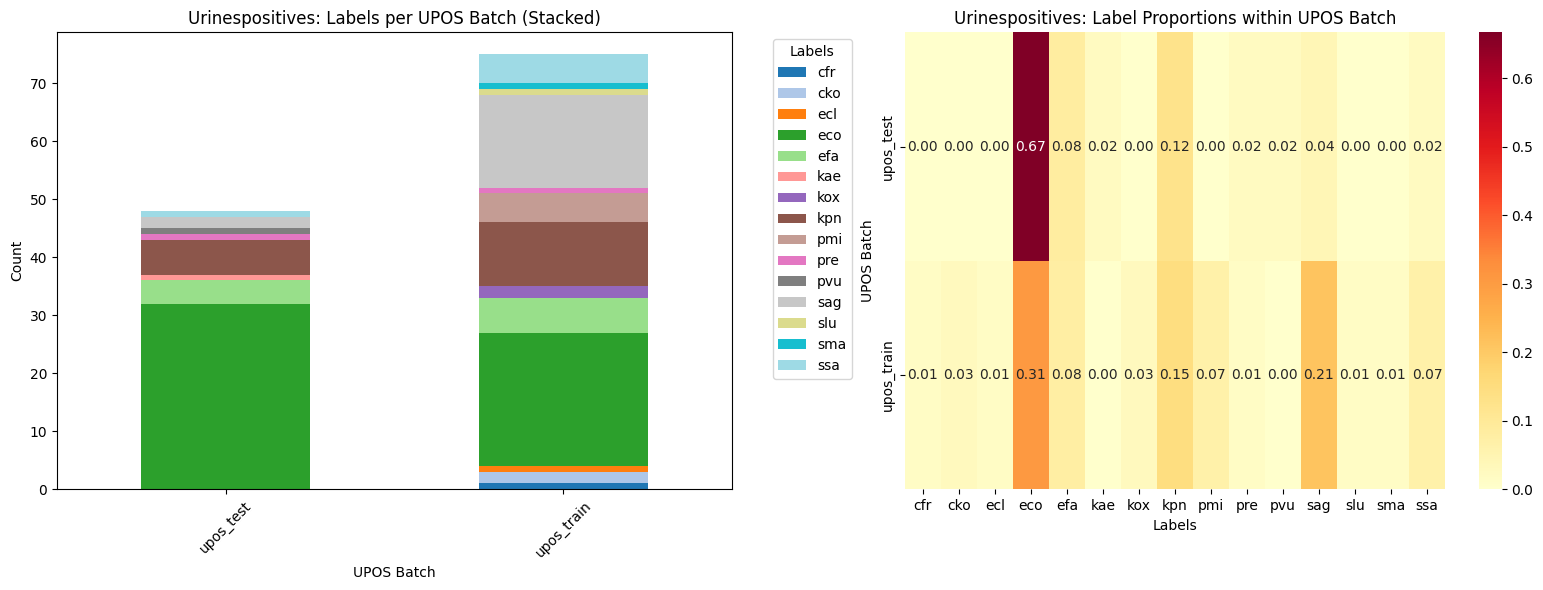


Urinespositives Crosstab:
label       cfr  cko  ecl  eco  efa  kae  kox  kpn  pmi  pre  pvu  sag  slu  \
upos_batch                                                                    
upos_test     0    0    0   32    4    1    0    6    0    1    1    2    0   
upos_train    1    2    1   23    6    0    2   11    5    1    0   16    1   

label       sma  ssa  
upos_batch            
upos_test     0    1  
upos_train    1    5  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create a comprehensive plot of all labels in each upos batch
def plot_labels_by_upos_batches(data):
    """
    Create visualizations showing the distribution of all labels in each upos batch
    """
    
    # Extract the relevant data
    upos_batches = data['upos_tests']['all']
    labels = data['labels']['all']
    
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'upos_batch': upos_batches,
        'label': labels
    })
    
    # Create crosstab for counts
    crosstab = pd.crosstab(df['upos_batch'], df['label'])
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Distribution of Labels across UPOS Batches', fontsize=16, fontweight='bold')
    
    # 1. Stacked bar chart
    ax1 = axes[0, 0]
    crosstab.plot(kind='bar', stacked=True, ax=ax1, colormap='tab20')
    ax1.set_title('Stacked Bar Chart: Labels per UPOS Batch')
    ax1.set_xlabel('UPOS Batch')
    ax1.set_ylabel('Count')
    ax1.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Heatmap of proportions
    ax2 = axes[0, 1]
    proportions = crosstab.div(crosstab.sum(axis=1), axis=0)
    sns.heatmap(proportions, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Heatmap: Label Proportions within each UPOS Batch')
    ax2.set_xlabel('Labels')
    ax2.set_ylabel('UPOS Batch')
    
    # 3. Grouped bar chart
    ax3 = axes[1, 0]
    crosstab.plot(kind='bar', ax=ax3, colormap='tab20')
    ax3.set_title('Grouped Bar Chart: Labels per UPOS Batch')
    ax3.set_xlabel('UPOS Batch')
    ax3.set_ylabel('Count')
    ax3.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Summary statistics table as text
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create summary statistics
    summary_text = "Summary Statistics:\n\n"
    summary_text += "Total samples per UPOS batch:\n"
    for batch in crosstab.index:
        total = crosstab.loc[batch].sum()
        summary_text += f"  {batch}: {total}\n"
    
    summary_text += "\nUnique labels per UPOS batch:\n"
    for batch in crosstab.index:
        unique_labels = (crosstab.loc[batch] > 0).sum()
        summary_text += f"  {batch}: {unique_labels}\n"
    
    summary_text += f"\nTotal unique labels: {len(crosstab.columns)}\n"
    summary_text += f"Total UPOS batches: {len(crosstab.index)}\n"
    
    ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed breakdown
    print("Detailed Breakdown of Labels by UPOS Batch:")
    print("=" * 50)
    for batch in crosstab.index:
        print(f"\n{batch.upper()}:")
        batch_data = crosstab.loc[batch]
        non_zero_labels = batch_data[batch_data > 0]
        for label, count in non_zero_labels.items():
            percentage = (count / batch_data.sum()) * 100
            print(f"  {label}: {count} samples ({percentage:.1f}%)")
    
    return crosstab

# Create the plot
crosstab_result = plot_labels_by_upos_batches(data)

# Display the crosstab as a DataFrame for reference
print("\nCrosstab Table (Counts):")
print(crosstab_result)

# Also create a separate detailed visualization focusing on urinespositives
print("\n" + "="*60)
print("FOCUSING ON URINESPOSITIVES DATA:")
print("="*60)

if 'urinespositives' in data['upos_tests']:
    upos_batches_urines = data['upos_tests']['urinespositives']
    labels_urines = data['labels']['urinespositives']
    
    df_urines = pd.DataFrame({
        'upos_batch': upos_batches_urines,
        'label': labels_urines
    })
    
    crosstab_urines = pd.crosstab(df_urines['upos_batch'], df_urines['label'])
    
    plt.figure(figsize=(12, 8))
    
    # Create subplot for urinespositives
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Stacked bar for urinespositives
    crosstab_urines.plot(kind='bar', stacked=True, ax=ax1, colormap='tab20')
    ax1.set_title('Urinespositives: Labels per UPOS Batch (Stacked)')
    ax1.set_xlabel('UPOS Batch')
    ax1.set_ylabel('Count')
    ax1.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # Proportions heatmap for urinespositives
    proportions_urines = crosstab_urines.div(crosstab_urines.sum(axis=1), axis=0)
    sns.heatmap(proportions_urines, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax2)
    ax2.set_title('Urinespositives: Label Proportions within UPOS Batch')
    ax2.set_xlabel('Labels')
    ax2.set_ylabel('UPOS Batch')
    
    plt.tight_layout()
    plt.show()
    
    print("\nUrinespositives Crosstab:")
    print(crosstab_urines)

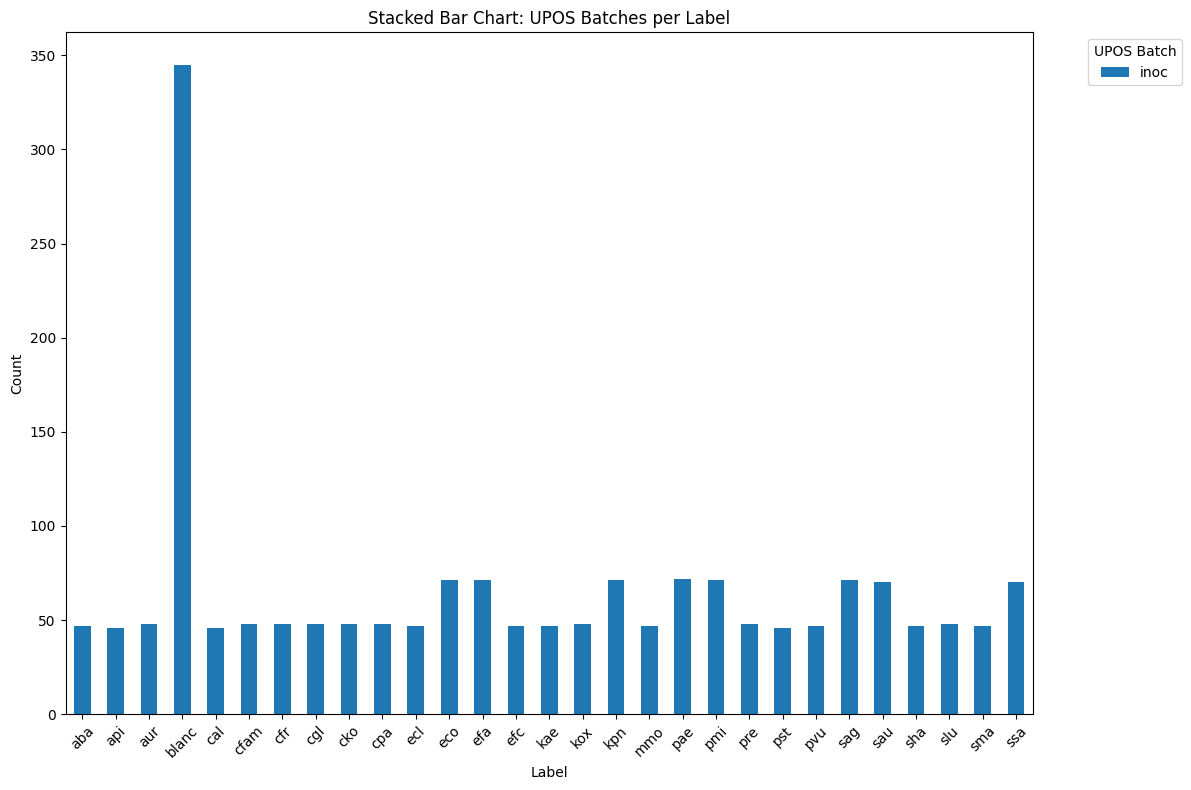

upos_batch,inoc
label,
aba,47
api,46
aur,48
blanc,345
cal,46
cfam,48
cfr,48
cgl,48
cko,48


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the DataFrame from your data dictionary
df = pd.DataFrame({
    'upos_batch': data['upos_tests']['all'],
    'label': data['labels']['all']
})

# Create a crosstab: rows=label, columns=upos_batch
crosstab_label = pd.crosstab(df['label'], df['upos_batch'])

# Plot: stacked bar, one bar per label, stacks are upos batches
ax = crosstab_label.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20'
)
ax.set_title('Stacked Bar Chart: UPOS Batches per Label')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.legend(title='UPOS Batch', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Optionally, display the crosstab table
crosstab_label

# upos batches composition

# Torchviz Visualization Example

Now you can create torchviz graphs and see which model each layer belongs to based on the naming convention:
- `classifier_*` layers belong to Classifier
- `classifier2_*` layers belong to Classifier2  
- `encoder_*` layers belong to Encoder
- `encoder2_*` layers belong to Encoder2
- `encoder3_*` layers belong to Encoder3
- `decoder_*` layers belong to Decoder
- `decoder2_*` layers belong to Decoder2
- `decoder3_*` layers belong to Decoder3

In [ ]:
# Example of how to use torchviz with the renamed layers
# Uncomment and run if you have torchviz installed

# from torchviz import make_dot
# import torch
# from msml.ml.models.pytorch.aedann import AutoEncoder2
# 
# # Create a model instance
# model = AutoEncoder2(
#     in_shape=100, n_batches=5, nb_classes=3, n_meta=0, n_emb=0,
#     mapper=True, variational=False, layer1=64, layer2=32, 
#     dropout=0.1, n_layers=2, prune_threshold=0.0
# )
# 
# # You can also create classifiers with softmax enabled:
# # classifier_with_softmax = Classifier(64, 10, n_layers=2, use_softmax=True)
# # classifier2_with_softmax = Classifier2(64, 128, 10, use_softmax=True)
# 
# # Create dummy input
# x = torch.randn(10, 100)
# to_rec = torch.randn(10, 100)
# batches = torch.randint(0, 5, (10,))
# 
# # Forward pass
# output = model(x, to_rec, batches)
# 
# # Create visualization
# dot = make_dot(output[0], params=dict(model.named_parameters()))
# dot.render("model_graph", format="png")
# 
# print("Graph saved as model_graph.png")
# print("Layer names now clearly show their parent model!")
# print("Classifiers now support optional softmax activation!")